In [1]:
from EEGModels import EEGNet, ShallowConvNet, DeepConvNet
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as layers
from tensorflow.keras.layers import GlobalMaxPooling2D, Activation, Dense, Conv1D, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization, GlobalMaxPooling1D
from tensorflow.keras import optimizers
import itertools
from sklearn.utils import shuffle

%matplotlib inline

##########################################################
##  DATA SOURCE:
##  https://github.com/bregydoc/bcidatasetIV2a
##  http://www.bbci.de/competition/iv/desc_2a.pdf
##########################################################

resource_folder='../resources/bcidatasetIV2a/'

In [2]:
train_datas = []
#eval_datas = []
for i in range(1,9):
    train_datas.append(np.load(resource_folder+'A0'+str(i)+'T.npz'))
    
#for i in range(1,9):
#    eval_datas.append(np.load(resource_folder+'A0'+str(i)+'E.npz'))
    
primary_motor_cortex_electrodes=[7,8,9,10,11]
random_electrodes = [1,4,13,20,21]
EOG_electrodes=[22,23,24]
############################################
event_codes=[769,770,771,772]
event_names=['left','right','foot','tounge']

#event_codes=[769,770]
#event_names=['left','right']
############################################



In [3]:
def showEvent(X,y):
    plt.rcParams["figure.figsize"] = [17, 2]
    fig, (c1, c2, c3, c4, c5) = plt.subplots(1, 5)
    #fig.suptitle(event_names[np.where(y==1)[0][0]])
    fig.suptitle(event_names[np.where(y>0.5)[0][0]])

    c1.plot(X[:,0])
    c2.plot(X[:,1])
    c3.plot(X[:,2])
    c4.plot(X[:,3])
    c5.plot(X[:,4])

In [25]:
X=[]
y=[]
i=0
for data in train_datas:
    signal = data['s']
    
    #REMOVE EOG
    #signal=np.delete(signal,EOG_electrodes,axis=1)
    
    #USE ONLY ELECTRODES OVER MOTOR CORTEX
    #signal = signal[:,primary_motor_cortex_electrodes]

    #USE 5 RANDOM ELECTRODES
    #signal = signal[:,random_electrodes]
        
    #FILTER BANDWIDTH
    signal=np.clip(signal,-20,20)
    signal=np.divide(signal, 20) #HASZNOS
    
    #signal=np.clip(signal,-30,30) #NEM NYERT
    #signal=np.divide(signal, 30)
    
    
    event_count=data['etyp'].shape[0]
    shift_multiplier=6
    for x in range(event_count): 
        epos = data['epos'].T[0, x]
        edur = data['edur'].T[0, x]
        etype= data['etyp'].T[0, x]
        if edur>10:
            if int(etype) in event_codes:
                for shift in range(-10,10):
                    trial = signal[epos+(shift*shift_multiplier):epos+(shift*shift_multiplier)+edur]
                    X.append(trial)
                    y.append(event_codes.index(etype))
                
    #FIRST PATIENT ONLY
    #break 
    
    #FIRST N PATINT ONLY
    #if i==4:
    #    break
    #i+=1
        
        
X=np.array(X)

y=to_categorical(np.array(y))
#############################################
#LABEL SMOOTHING
smooth_value=0.95
y*=smooth_value
smooth_min=(1-smooth_value)/(y.shape[1]-1)
y=np.where(y==0, smooth_min, y) 
#############################################
print(X.shape)
print(y.shape)


(46080, 313, 25)
(46080, 4)


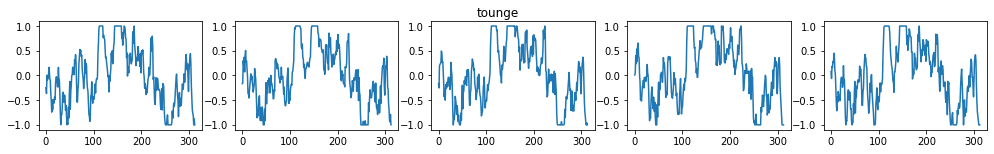

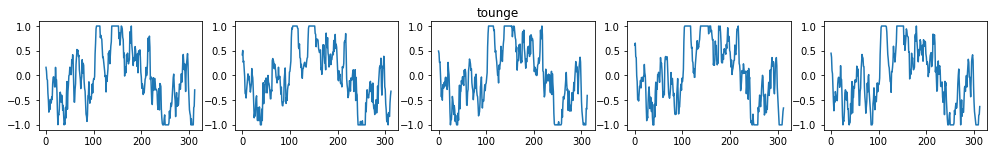

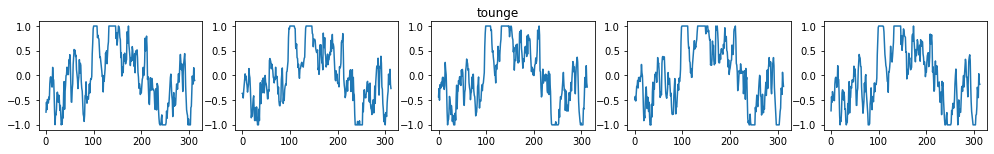

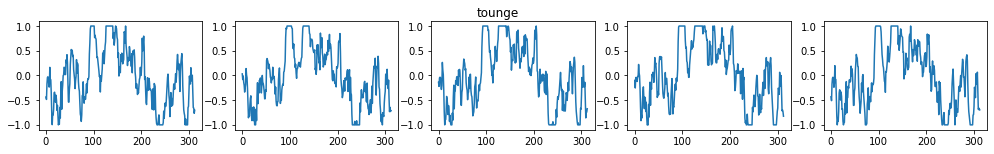

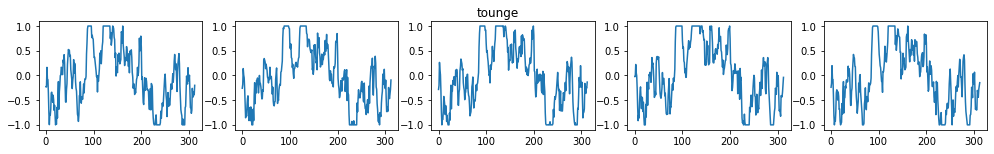

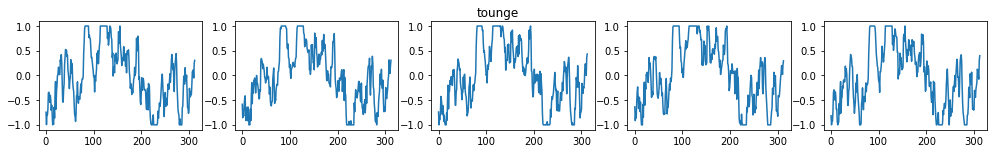

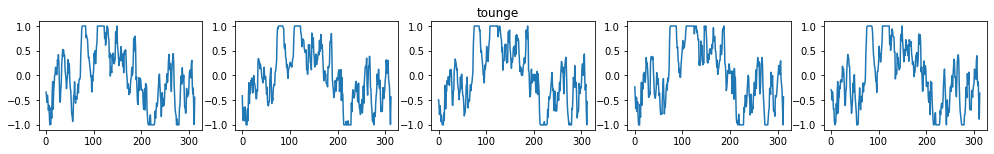

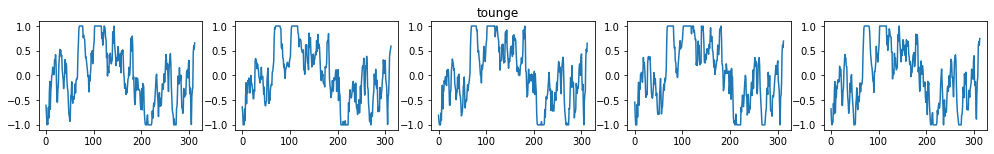

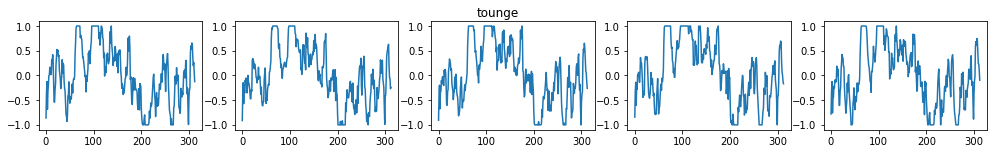

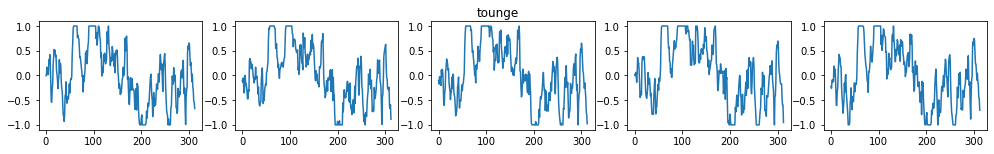

In [26]:
for i in range(len(X)):
    showEvent(X[i],y[i])
    if i == 9:
        break

In [27]:
#SHUFFLE INCLUDED
#X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.1, random_state=16)
#X_val, X_test, y_val, y_test=train_test_split(X_temp, y_temp, test_size=0.5)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.05, random_state=16)
X_val, X_test, y_val, y_test=train_test_split(X_temp, y_temp, test_size=0.5)
print(X_train.shape)
print(y_train.shape)
print()
print(X_val.shape)
print(y_val.shape)
print()
print(X_test.shape)
print(y_test.shape)
print()

(43776, 313, 25)
(43776, 4)

(1152, 313, 25)
(1152, 4)

(1152, 313, 25)
(1152, 4)



In [28]:
def get_model():
    inspected_chanels=signal.shape[1]
    signal_length=313
    input_layer = keras.Input(shape = (signal_length,inspected_chanels,1), name='input')
    x     = layers.Conv2D(64, kernel_size=(5,1), padding='same', activation='relu')(input_layer)
    x     = layers.Conv2D(32, kernel_size=(1,5), padding='same', activation='relu')(x)
    x     = layers.Conv2D(16, 16, padding='same', activation='relu')(x)
    x     = layers.Conv2D(8, 8, padding='same', activation='relu')(x)
    x     = layers.Conv2D(4, 4, padding='same', activation='relu')(x)
    x     = layers.GlobalAveragePooling2D()(x)
    x     = layers.Dense(8)(x)
    x     = layers.Dense(64)(x)
    output = layers.Dense(len(event_codes), activation='softmax')(x)
    #output = layers.Dense(1, activation='softmax')(x)

    model = keras.Model(inputs=input_layer, outputs=output)

    model.summary()
    return model

In [29]:
# IN CASE EEGNET
X_train=np.transpose(X_train,(0,2,1))
X_val=  np.transpose(X_val,(0,2,1))
X_test= np.transpose(X_test,(0,2,1))


In [30]:
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [31]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

#strategy = tf.distribute.MirroredStrategy()
#print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
#with strategy.scope():



#model = get_model()
#model = get_dummy_model()

#model=EEGNet(nb_classes=len(event_codes),
#            Chans=signal.shape[1],
#            Samples = 313,
#            kernLength = 125,#EEGNet wrote best is half of sampling rate
#            )

model=EEGNet(nb_classes=len(event_codes),
            Chans=signal.shape[1],
            Samples = 313,
            kernLength = 125,#EEGNet wrote best is half of sampling rate ##NA EZAZ AMIT A HS-CNN BUZERÁL
            F1=16,
            F2=32,
            D=4,
            )

opt = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=opt,
          #loss='binary_crossentropy',
          loss='categorical_crossentropy',
          metrics=['accuracy']
         )

model.summary()
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    batch_size=32,
                    epochs=10, 
                    shuffle=True,
                    callbacks=[callback])


Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 25, 313, 1)]      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 313, 16)       2000      
_________________________________________________________________
batch_normalization_6 (Batch (None, 25, 313, 16)       64        
_________________________________________________________________
depthwise_conv2d_2 (Depthwis (None, 1, 313, 64)        1600      
_________________________________________________________________
batch_normalization_7 (Batch (None, 1, 313, 64)        256       
_________________________________________________________________
activation_4 (Activation)    (None, 1, 313, 64)        0         
_________________________________________________________________
average_pooling2d_4 (Average (None, 1, 78, 64)        

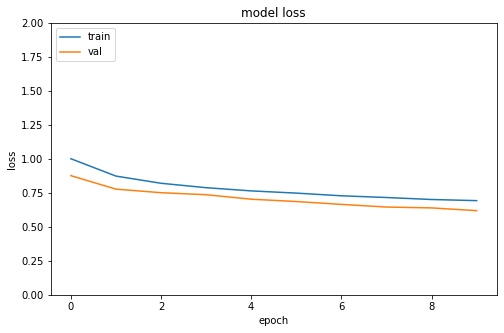

In [35]:
plt.rcParams["figure.figsize"] = [8, 5]
plt.ylim([0, 2])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

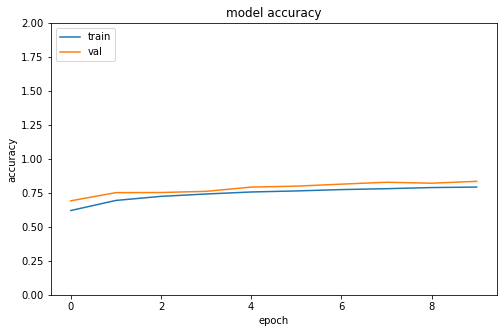

In [36]:
plt.ylim([0, 2])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## PREDICT

In [37]:
summ, correct, incorrect = 0, 0, 0

for i in range(len(X_test)):
    #print(y_test[i])
    #gt = np.where(y_test[i]== 1)[0][0]
    gt = np.where(y_test[i]>0.5)[0][0]

    #print(gt)
    input_data=X_test[i]
    #print("#################")
    #print(input_data.shape)
    
    #Doesn't matter?
    input_data=np.expand_dims(input_data, axis=0)
    
    #print(input_data.shape)
    input_data=np.expand_dims(input_data, axis = -1)
    #print(input_data.shape)

    
    #print("#################")
    #print(input_data.shape)
    result = model.predict(input_data)[0]
    #print(result)
    prediction = np.where(result == np.amax(result))[0][0]
    #print(prediction)
    summ+=1
    if gt==prediction:
        correct+=1
    else:
        incorrect+=1
    #print()
print("SUMM:{} | correct: {} | incorrect: {}".format(summ, correct, incorrect))
print("Accuracy: {}%".format(round((correct/summ)*100,2)))


SUMM:1152 | correct: 972 | incorrect: 180
Accuracy: 84.38%


In [1]:
!nvidia-smi

Sun May 23 11:03:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 461.92       Driver Version: 461.92       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 106... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   58C    P0    29W / 120W |    453MiB /  6144MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 106... WDDM  | 00000000:03:00.0  On |                  N/A |
| 27%   